In [1]:
%matplotlib inline
from solveLongRanged import linearSolve_krylov as linearSolve
from solveLRdirect import linearSolve_direct
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(6*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    S[i + 5*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)  #-(S[i] + S[i + 3*Np])  ##use tracelessness 
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] - 1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np] - 1.)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
        S[i + 5*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)  #-(S[i] + S[i + 3*Np])  ##use tracelessness 
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=time_points, **kwargs)
        
    return X

In [7]:
%%time
#initiallize system and forces
ls = linearSolve_direct(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 1000.
Npts = 100

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1,
             method='RK45')
X.message

CPU times: user 3min 12s, sys: 1min 7s, total: 4min 19s
Wall time: 35.7 s


'The solver successfully reached the end of the integration interval.'

In [8]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [9]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

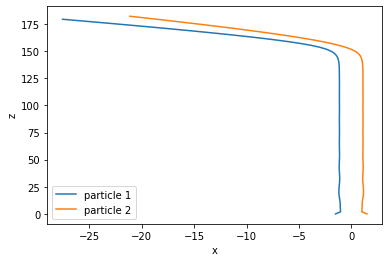

In [64]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,2], label='particle 1')
plt.plot(pos2[:,0], pos2[:,2], label='particle 2')
plt.xlabel('x')
plt.ylabel('z')
#plt.xlim(-1.2,-1.)
plt.legend()
plt.show()

In [11]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0441598328759056, 8.541938963965706)

In [12]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([1]),)

In [13]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0441598328759056, 0.0, 0.0)

In [14]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [65]:
print(pos1[:,2] - pos2[:,2])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.55271368e-15  0.00000000e+00
  3.55271368e-15  1.06581410e-14  2.13162821e-14  3.55271368e-14
  7.10542736e-14  9.94759830e-14  1.56319402e-13  2.27373675e-13
  3.55271368e-13  5.68434189e-13  9.45021839e-13  1.59161573e-12
  2.67164069e-12  4.42668124e-12  7.19779791e-12  1.16244792e-11
  1.87085902e-11  2.97788461e-11  4.66613415e-11  7.38111794e-11
  1.17964305e-10  1.86986426e-10  3.01284331e-10  4.96228836e-10
  8.21728463e-10  1.34836853e-09  2.21930918e-09  3.53112739e-09
  5.56343593e-09  8.83912321e-09  1.41243248e-08  2.24642775e-08
  3.59135157e-08  5.83234083e-08  9.54077279e-08  1.55755103e-07
  2.52536395e-07  4.05008024e-07  6.51330922e-07  1.04955971e-06
  1.69410896e-06  2.69468656e-06  4.26709778e-06  6.85723137e-06
  1.11431410e-05  1.82340

In [52]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta, tolerance=1e-10)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 1000.
Npts = 100

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1,
             method='RK45')
X.message

CPU times: user 3min 14s, sys: 159 ms, total: 3min 14s
Wall time: 2min 36s


'The solver successfully reached the end of the integration interval.'

In [53]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [54]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

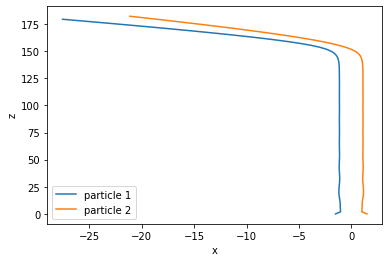

In [63]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,2], label='particle 1')
plt.plot(pos2[:,0], pos2[:,2], label='particle 2')
plt.xlabel('x')
plt.ylabel('z')
#plt.xlim(-1.2,-1.)
plt.legend()
plt.show()

In [56]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0441598328881954, 7.005935080486422)

In [57]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([1]),)

In [58]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0441598328881954, 0.0, 0.0)

In [59]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [67]:
print(pos1[:,2] - pos2[:,2])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.55271368e-15  0.00000000e+00
  3.55271368e-15  1.06581410e-14  2.13162821e-14  3.55271368e-14
  7.10542736e-14  9.94759830e-14  1.56319402e-13  2.27373675e-13
  3.55271368e-13  5.68434189e-13  9.45021839e-13  1.59161573e-12
  2.67164069e-12  4.42668124e-12  7.19779791e-12  1.16244792e-11
  1.87085902e-11  2.97788461e-11  4.66613415e-11  7.38111794e-11
  1.17964305e-10  1.86986426e-10  3.01284331e-10  4.96228836e-10
  8.21728463e-10  1.34836853e-09  2.21930918e-09  3.53112739e-09
  5.56343593e-09  8.83912321e-09  1.41243248e-08  2.24642775e-08
  3.59135157e-08  5.83234083e-08  9.54077279e-08  1.55755103e-07
  2.52536395e-07  4.05008024e-07  6.51330922e-07  1.04955971e-06
  1.69410896e-06  2.69468656e-06  4.26709778e-06  6.85723137e-06
  1.11431410e-05  1.82340